# Libreries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

#import keras
from tensorflow.keras.layers import Layer, Conv2D, AveragePooling2D, Flatten, Dense, Softmax, ReLU
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.constraints import NonNeg

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import random

from scipy import signal


# Layer definition

In [2]:
class GDN(Layer):
    def __init__(self, 
                 filter_shape = (3,3), 
                 **kwargs):
      
        self.filter_shape = filter_shape

        super(GDN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.beta = self.add_weight(name = 'beta', 
                                    shape = (input_shape.as_list()[-1]),
                                    initializer = tf.keras.initializers.constant(0.001),
                                    trainable = True,
                                    constraint = lambda x: tf.clip_by_value(x, 1e-15, np.inf))
        
        self.alpha = self.add_weight(name = 'alpha', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(2.0),
                                     trainable = True,
                                     constraint = NonNeg())

        self.epsilon = self.add_weight(name = 'epsilon', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(0.5),
                                     trainable = True,
                                     constraint = NonNeg())
        
        self.gamma = self.add_weight(name = 'gamma', 
                                     shape = (self.filter_shape[0], self.filter_shape[1], input_shape.as_list()[-1], input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.Ones,
                                     trainable = True,
                                     constraint = NonNeg())
        
        
        super(GDN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        norm_conv2 = tf.nn.convolution(tf.abs(x)**self.alpha,
                                      self.gamma,
                                      strides = (1, 1),
                                      padding = "SAME",
                                      data_format = "NHWC")

        norm_conv = self.beta + norm_conv2
        norm_conv = norm_conv**self.epsilon
        return x / norm_conv
        
    def compute_output_shape(self, input_shape):
        return (input_shape, self.output_dim)

# Tests

## MNIST

In [3]:
# Download mnist data and split into train and test sets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Normalize and reshape
x_train_mnist = x_train_mnist/255.
x_test_mnist = x_test_mnist/255.

x_train_mnist = x_train_mnist.reshape(60000, 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(10000, 28, 28, 1)

print(x_train_mnist.shape[1:4])

(28, 28, 1)


In [5]:
# Model with GDN
model = Sequential()
model.add(GDN(input_shape = x_train_mnist.shape[1:4]))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn (GDN)                    (None, 28, 28, 1)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Check model weights
model.get_weights()

[array([0.001], dtype=float32),
 array([2.], dtype=float32),
 array([0.5], dtype=float32),
 array([[[[1.]],
 
         [[1.]],
 
         [[1.]]],
 
 
        [[[1.]],
 
         [[1.]],
 
         [[1.]]],
 
 
        [[[1.]],
 
         [[1.]],
 
         [[1.]]]], dtype=float32)]

In [7]:
# Apply model
x_train_mnist_out = model.apply(x_train_mnist)
print(x_train_mnist_out.shape)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(60000, 28, 28, 1)


In [8]:
np.max(x_train_mnist_out[0])

0.52723897

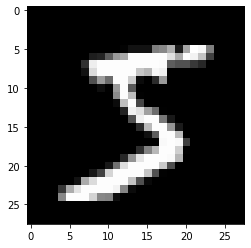

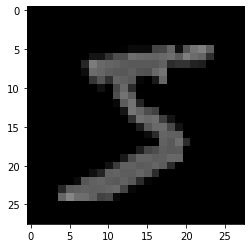

In [9]:
# Visualize model results
plt.imshow(tf.squeeze(x_train_mnist[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()
plt.imshow(tf.squeeze(x_train_mnist_out[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

In [10]:
# Do it by hand
test_1 = x_train_mnist[0][:,:,:]
print(np.matrix(test_1[15:20,15:20]), test_1.shape)
test_2 = test_1 ** [2]
print(np.matrix(test_2[15:20,15:20]), test_2.shape)
test_3 = signal.convolve(test_2, np.array([[1,1,1],[1,1,1],[1,1,1]]).reshape(3,3,1), mode = 'same', method = 'direct')
print(np.matrix(test_3[15:20,15:20]), test_3.shape)
test_4 = test_3 + 0.001
print(np.matrix(test_4[15:20,15:20]), test_4.shape)
test_5 = test_4 ** [0.5]
print(np.matrix(test_5[15:20,15:20]), test_5.shape)
test_6 = test_1 / test_5
print(np.matrix(test_6[15:20,15:20]), test_6.shape)

[[0.72941176 0.99215686 0.99215686 0.58823529 0.10588235]
 [0.0627451  0.36470588 0.98823529 0.99215686 0.73333333]
 [0.         0.         0.97647059 0.99215686 0.97647059]
 [0.50980392 0.71764706 0.99215686 0.99215686 0.81176471]
 [0.99215686 0.99215686 0.99215686 0.98039216 0.71372549]] (28, 28, 1)
[[0.53204152 0.98437524 0.98437524 0.34602076 0.01121107]
 [0.00393695 0.13301038 0.976609   0.98437524 0.53777778]
 [0.         0.         0.95349481 0.98437524 0.95349481]
 [0.25990004 0.5150173  0.98437524 0.98437524 0.65896194]
 [0.98437524 0.98437524 0.98437524 0.96116878 0.50940408]] (28, 28, 1)
[[4.53906959 5.80087659 5.62053057 4.06775855 1.88899654]
 [1.68450596 4.56784314 6.34663591 6.73173395 3.88024606]
 [0.944406   3.82634371 6.51563245 8.01783929 5.16641292]
 [3.58268358 5.66591311 7.35155709 7.97402537 5.11483276]
 [6.5358093  7.30248366 7.11294118 5.79753941 3.20753556]] (28, 28, 1)
[[4.54006959 5.80187659 5.62153057 4.06875855 1.88999654]
 [1.68550596 4.56884314 6.3476359

In [11]:
# Check the result is the same
print(np.matrix(np.array(x_train_mnist_out[0][15:20,15:20,:]).reshape(5,5)))

[[0.34232727 0.41190407 0.41845918 0.29162192 0.07701815]
 [0.04832976 0.17062384 0.39224228 0.3823707  0.37223387]
 [0.         0.         0.3825142  0.35036814 0.42955884]
 [0.26930127 0.30146557 0.36589894 0.35132924 0.35889882]
 [0.38805872 0.36712614 0.3719848  0.40713698 0.39845362]]


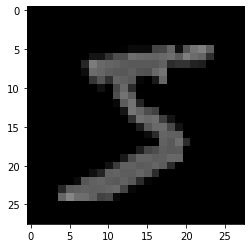

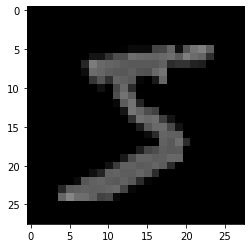

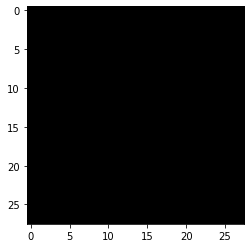

In [12]:
# Visualize the model and the handmade results
plt.imshow(test_6.reshape([28,28]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()
plt.imshow(tf.squeeze(x_train_mnist_out[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()
plt.imshow(test_6.reshape([28,28])-tf.squeeze(x_train_mnist_out[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

## Fashion MNIST

In [13]:
# Download the data and split into train and test
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [14]:
# Normalize and reshape
x_train_fmnist = x_train_fmnist/255.
x_test_fmnist = x_test_fmnist/255.

x_train_fmnist = x_train_fmnist.reshape(60000, 28, 28, 1)
x_test_fmnist = x_test_fmnist.reshape(10000, 28, 28, 1)

In [15]:
# Model with GDN
model_f = Sequential()
model_f.add(GDN(input_shape = x_train_fmnist.shape[1:4]))

model_f.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model_f.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_1 (GDN)                  (None, 28, 28, 1)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Apply the model
x_train_fmnist_out = model_f.apply(x_train_fmnist)
print(x_train_fmnist_out.shape)

(60000, 28, 28, 1)


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


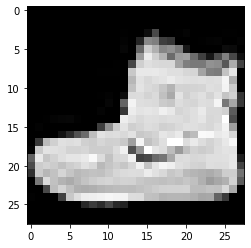

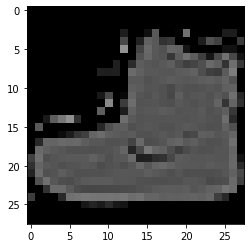

In [17]:
# Visualize the results
plt.imshow(tf.squeeze(x_train_fmnist[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()
plt.imshow(tf.squeeze(x_train_fmnist_out[0]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

## Cifar10

In [18]:
# Download the data and divede into train and test
(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = cifar10.load_data()

# Normalize, reshape and one hot encoding
x_train_c10 = x_train_c10/255.
x_test_c10 = x_test_c10/255.

x_train_c10 = x_train_c10.reshape(50000, 32, 32, 3)
x_test_c10 = x_test_c10.reshape(10000, 32, 32, 3)

y_train_c10 = to_categorical(y_train_c10)
y_test_c10 = to_categorical(y_test_c10)

170508288/170498071 [==============================] - 2s 0us/step


In [19]:
# Define model with GDN
model1 = Sequential()
model1.add(GDN(input_shape = x_train_c10.shape[1:4]))
model1.add(Conv2D(32, 3))
model1.add(AveragePooling2D())
model1.add(GDN())
model1.add(Conv2D(32, 3))
model1.add(AveragePooling2D())
model1.add(Flatten())
model1.add(Dense(10))
model1.add(Softmax())


model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_2 (GDN)                  (None, 32, 32, 3)         90        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
gdn_3 (GDN)                  (None, 15, 15, 32)        9312      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [20]:
# Check weights
pesos_model1 = model1.get_weights()
pesos_model1

[array([0.001, 0.001, 0.001], dtype=float32),
 array([2., 2., 2.], dtype=float32),
 array([0.5, 0.5, 0.5], dtype=float32),
 array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], dtype=float32),
 array([[[[ 1.14240184e-01,  8.45758617e-02, -8.36053044e-02,
           -4.74483892e-02,  7.63117671e-02,  8.14924538e-02,
            1.19741991e-01, -1.12242952e-01, -1.11329183

In [21]:
# Train the model
model1.fit(x_train_c10, y_train_c10, epochs = 5, batch_size = 32)

Epoch 1/5
1563/1563 [==============================] - 16s 9ms/step - loss: 1.7978 - accuracy: 0.3560
Epoch 2/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5995 - accuracy: 0.4351
Epoch 3/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5218 - accuracy: 0.4586
Epoch 4/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4504 - accuracy: 0.4863
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4036 - accuracy: 0.5034


In [22]:
# Check the weights have trained
pesos_model1_out = model1.get_weights()
pesos_model1_out

[array([0.0047919 , 0.00183214, 0.05054513], dtype=float32),
 array([1.9422221, 1.7729342, 2.0638149], dtype=float32),
 array([0.41934374, 0.518081  , 0.34110838], dtype=float32),
 array([[[[0.7919088 , 1.1983207 , 1.0366554 ],
          [1.1437736 , 1.0074103 , 0.99684817],
          [1.1037629 , 1.1813184 , 0.7274224 ]],
 
         [[0.7650657 , 1.1450663 , 1.0938131 ],
          [1.1270642 , 0.94714576, 1.0433797 ],
          [1.1410066 , 1.1560954 , 0.77610976]],
 
         [[0.7563028 , 1.1886603 , 1.0233235 ],
          [1.0728288 , 0.9771084 , 0.99793303],
          [1.0421348 , 1.1635737 , 0.74889195]]],
 
 
        [[[0.504355  , 0.9503293 , 1.0443063 ],
          [1.010193  , 0.811591  , 0.9882764 ],
          [1.0320983 , 1.0091379 , 0.67641515]],
 
         [[0.4699161 , 0.910713  , 1.1191578 ],
          [0.99910724, 0.76726896, 1.0479747 ],
          [1.0873425 , 0.9997183 , 0.7318839 ]],
 
         [[0.50290614, 0.99320984, 1.0520557 ],
          [0.98861635, 0.83093977,

## Cifar 10 modifying the images

In [23]:
# Change image contrast
x_train_c10_new, x_test_c10_new = [], []
for i in range(x_train_c10.shape[0]):
  x_train_c10_new.append(x_train_c10[i]*random.uniform(0.2, 1))
for i in range(x_test_c10.shape[0]):
  x_test_c10_new.append(x_test_c10[i]*random.uniform(0.2, 1))

x_train_c10_new = np.array(x_train_c10_new)
x_test_c10_new = np.array(x_test_c10_new)

print(x_train_c10.shape, x_train_c10_new.shape)
print(y_train_c10.shape)
print(x_test_c10.shape, x_test_c10_new.shape)
print(y_test_c10.shape)

(50000, 32, 32, 3) (50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3) (10000, 32, 32, 3)
(10000, 10)


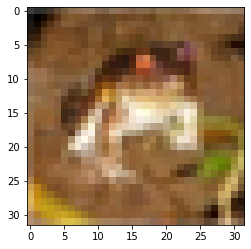

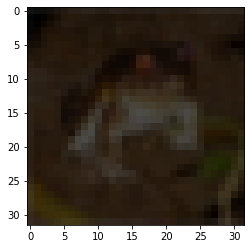

In [24]:
# Visualize
plt.imshow(x_train_c10[0], vmin = 0, vmax = 1)
plt.show()
plt.imshow(x_train_c10_new[0], vmin = 0, vmax = 1)
plt.show()

In [25]:
# Model with GDN
model_GDN = Sequential()
model_GDN.add(GDN(input_shape = x_train_c10_new.shape[1:4]))
model_GDN.add(Conv2D(32, 3))
model_GDN.add(AveragePooling2D())
model_GDN.add(GDN())
model_GDN.add(Conv2D(32, 3))
model_GDN.add(AveragePooling2D())
model_GDN.add(Flatten())
model_GDN.add(Dense(10))
model_GDN.add(Softmax())


model_GDN.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model_GDN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_4 (GDN)                  (None, 32, 32, 3)         90        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
gdn_5 (GDN)                  (None, 15, 15, 32)        9312      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [26]:
# Fit the model
history_GDN = model_GDN.fit(x_train_c10_new, y_train_c10, epochs = 10, batch_size = 32)

Epoch 1/10
1563/1563 [==============================] - 14s 8ms/step - loss: 1.7913 - accuracy: 0.3571
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6117 - accuracy: 0.4294
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5285 - accuracy: 0.4550
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4689 - accuracy: 0.4795
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4383 - accuracy: 0.4916
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4150 - accuracy: 0.4979
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.3917 - accuracy: 0.5071
Epoch 8/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.3728 - accuracy: 0.5123
Epoch 9/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.3486 - accuracy: 0.5207
Epoch 10/10
1563/1563 [==============================] - 13s 8ms/step - l

In [27]:
# Evaluate GDN model
model_GDN.evaluate(x_test_c10_new, y_test_c10)

313/313 [==============================] - 2s 5ms/step - loss: 1.3637 - accuracy: 0.5181


[1.3636754751205444, 0.5181000232696533]

In [28]:
# Model without GDN
model_NO_GDN = Sequential()
#model_NO_GDN.add(GDN(input_shape = x_train_new.shape[1:4]))
model_NO_GDN.add(Conv2D(32, 3, input_shape = x_train_c10_new.shape[1:4]))
model_NO_GDN.add(AveragePooling2D())
#model_NO_GDN.add(GDN())
model_NO_GDN.add(Conv2D(32, 3))
model_NO_GDN.add(AveragePooling2D())
model_NO_GDN.add(Flatten())
model_NO_GDN.add(Dense(10))
model_NO_GDN.add(Softmax())

model_NO_GDN.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model_NO_GDN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
average_pooling2d_5 (Average (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                11530     
_________________________________________________________________
softmax_2 (Softmax)          (None, 10)               

In [29]:
# Fit the model
history_NO_GDN = model_NO_GDN.fit(x_train_c10_new, y_train_c10, epochs = 10, batch_size = 32)

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9067 - accuracy: 0.3439
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8342 - accuracy: 0.3815
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8176 - accuracy: 0.3875
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8087 - accuracy: 0.3932
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8033 - accuracy: 0.3960
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7970 - accuracy: 0.3973
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7928 - accuracy: 0.3990
Epoch 8/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7895 - accuracy: 0.4005
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7867 - accuracy: 0.4005
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.784

In [30]:
# Evaluate NO GDN model
model_NO_GDN.evaluate(x_test_c10_new, y_test_c10)

313/313 [==============================] - 1s 4ms/step - loss: 1.8315 - accuracy: 0.3857


[1.831450343132019, 0.385699987411499]

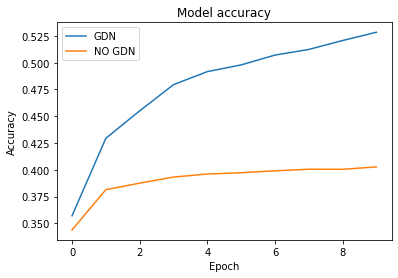

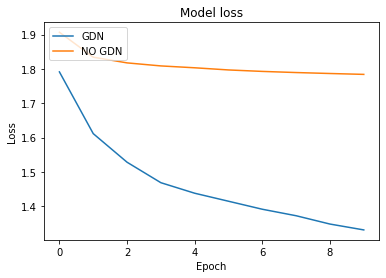

In [31]:
# Plot results
plt.plot(history_GDN.history['accuracy'])
plt.plot(history_NO_GDN.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GDN', 'NO GDN'], loc = 'upper left')
plt.show()

plt.plot(history_GDN.history['loss'])
plt.plot(history_NO_GDN.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['GDN', 'NO GDN'], loc = 'upper left')
plt.show()